In [1]:
import json
import os
import numpy as np
import itertools

from transformers import PreTrainedTokenizerFast, AutoTokenizer, AutoConfig
from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from notebook_utils import *

In [3]:
# disable FutureWarning from seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the results for UD

In [4]:
result_dir = "../../../models"

languages = ('ar', 'zh', 'el', 'tr', 'es', 'en')

tokenizer_types = ('bpe-tokenization', 'merged-tokenization', 'multilingual-tokenization', 'nooverlap-tokenization')
vocab_sizes = (120000, 120000, 120000, 20000)

In [11]:
task = 'UD'
metric = 'accuracy'

results = []

post_training = 'PROBE'
seeds = [2000]

for seed in seeds:
    for lang_src in languages:
        for lang_tgt in languages:
            for tok_type, vocab_size in zip(tokenizer_types, vocab_sizes):
                result_file = f"{result_dir}/{task}_{post_training}/{tok_type}/alpha-0.25_alpha-train-0.25_N-{vocab_size}_{seed}/{lang_src}/{metric}_evaluation/{lang_tgt}/{metric}_all.txt"
                
                if not os.path.exists(result_file):
                    print("not found! skipping", result_file)
                    continue
                with open(result_file, 'r') as in_file:
                    res = json.load(in_file)[f'eval_{metric}']

                results.append(
                    {
                        'lang_src': lang_src,
                        'lang_tgt': lang_tgt,
                        'tokenizer_type': tok_type,
                        'post_training': post_training,
                        'seed': seed,
                        'vocab_size': vocab_size,
                        metric: res
                    }
                )

In [12]:
df_all = pd.DataFrame(results)
# df_all['lang_src'] = pd.Categorical(df_all['lang_src'], categories=df_all['lang_src'].unique())
# df_all['lang_tgt'] = pd.Categorical(df_all['lang_tgt'], categories=df_all['lang_tgt'].unique())

In [13]:
df_all

,lang_src,lang_tgt,tokenizer_type,post_training,seed,vocab_size,accuracy
0,ar,ar,bpe-tokenization,PROBE,2000,120000,0.318352
1,ar,ar,merged-tokenization,PROBE,2000,120000,0.331720
2,ar,ar,multilingual-tokenization,PROBE,2000,120000,0.322309
3,ar,ar,nooverlap-tokenization,PROBE,2000,20000,0.323931
4,ar,zh,bpe-tokenization,PROBE,2000,120000,0.032301
...,...,...,...,...,...,...,...
139,en,es,nooverlap-tokenization,PROBE,2000,20000,0.726395
140,en,en,bpe-tokenization,PROBE,2000,120000,0.898191
141,en,en,merged-tokenization,PROBE,2000,120000,0.892652
142,en,en,multilingual-tokenization,PROBE,2000,120000,0.841847


In [14]:
def plot_boxplot(df, post_training, title, ax=None):
    df = df[df['post_training'] == post_training]
    ax = sns.boxplot(x='tokenizer_type', y=metric, data=df, showmeans=True, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(title)

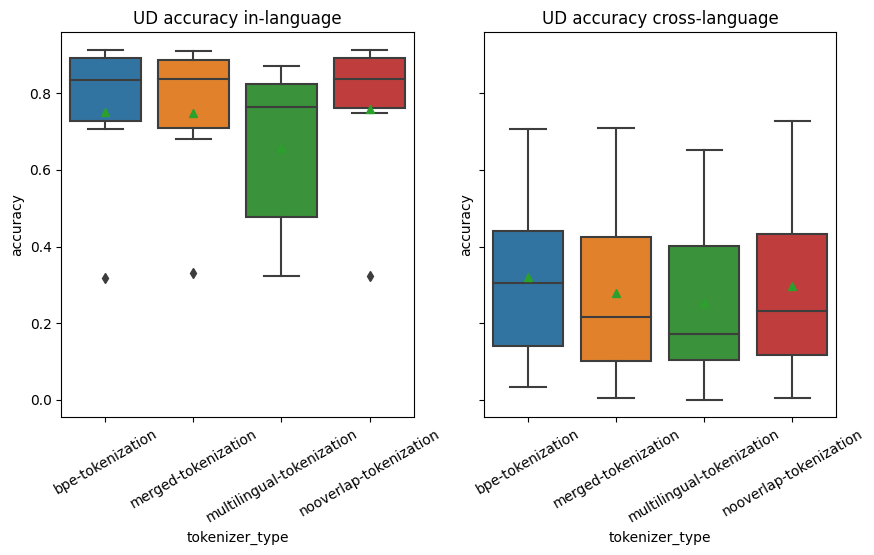

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# inlang
df = df_all[df_all['lang_src'] == df_all['lang_tgt']]
plot_boxplot(df, 'PROBE', f"{task} {metric} in-language", ax=ax[0])
# crosslang
df = df_all[df_all['lang_src'] != df_all['lang_tgt']]
plot_boxplot(df, 'PROBE', f"{task} {metric} cross-language", ax=ax[1])

In [10]:
def plot_heatmaps(df, baseline, baseline_title, compared=[], compared_titles=[], figsize=None):
    # plot heatmap for lang_src and lang_tgt with `metric` as value for tokenizer_type == 'multilingual-tokenization'
    # make 3 plots horizontally
    figsize = figsize if figsize is not None else (30/4*(1+len(compared)), 5)
    fig, axs = plt.subplots(1, 1+len(compared), squeeze=False, figsize=figsize)
    df_baseline = df[baseline]
    # average over the seeds
    df_baseline = df_baseline.groupby(['lang_src', 'lang_tgt', 'tokenizer_type']).mean().reset_index()
    df_baseline = df_baseline.pivot("lang_src", "lang_tgt", metric)
    sns.heatmap(df_baseline, annot=True, fmt=".2f", cmap="YlGnBu", ax=axs[0][0])
    axs[0][0].set_title(f"UD {metric} with {baseline_title}")
    # plt.show()
    # plot heatmaps for the rest of the tokenizer_types as a delta to 'multilingual-tokenization'
    for i, comp, compared_title in zip(range(1, len(compared)+1), compared, compared_titles):
        ax = axs[0][i]
        df_delta = df[comp]
        df_delta = df_delta.groupby(['lang_src', 'lang_tgt', 'tokenizer_type']).mean().reset_index()
        df_delta = df_delta.pivot("lang_src", "lang_tgt", metric)
        df_delta = df_delta - df_baseline
        # choose a diverging colormap
        # set the scale to be between -1 and 1
        sns.heatmap(df_delta, annot=True, fmt=".2f", cmap="RdBu", vmin=-0.1, vmax=0.1, ax=ax)
        ax.set_title(f"{compared_title} - {baseline_title}")
    plt.show()

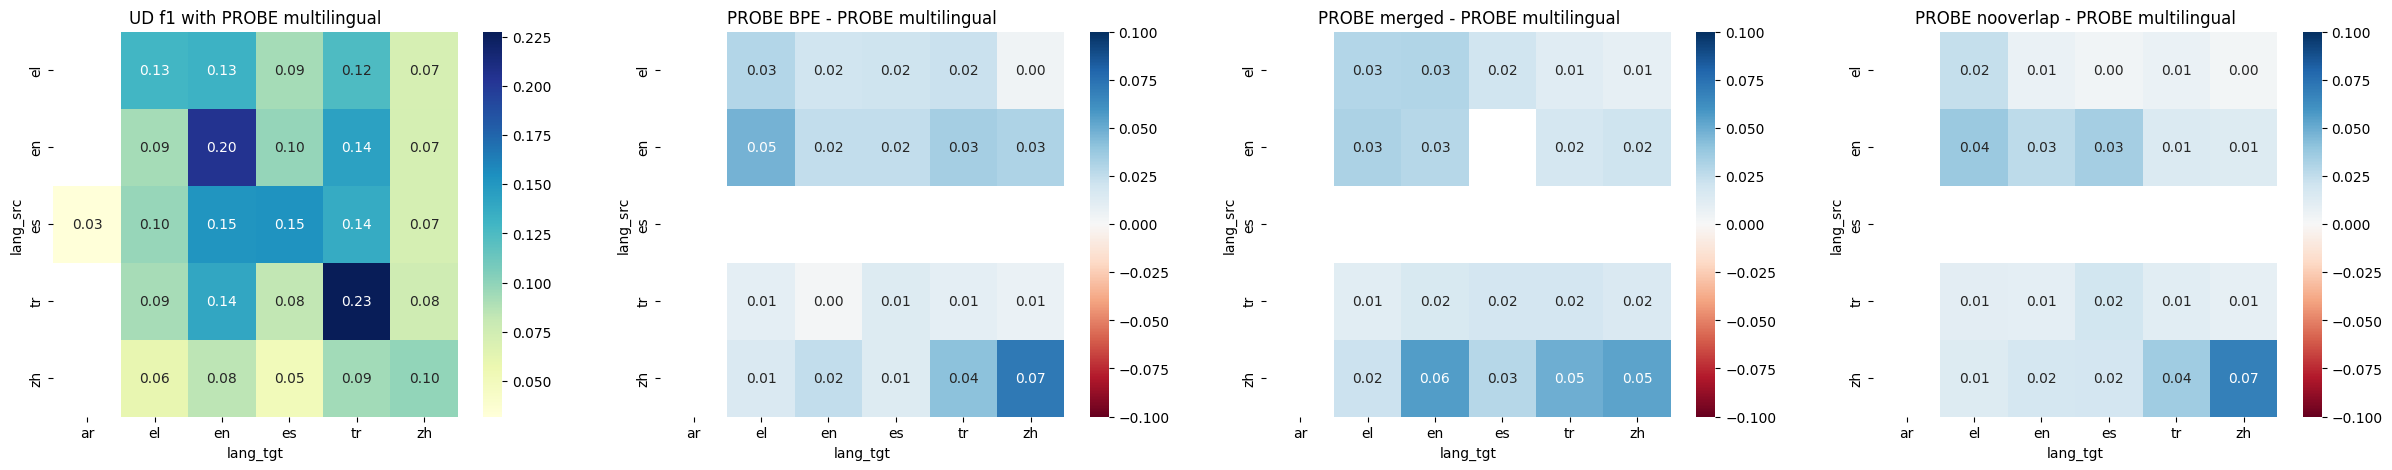

In [11]:
post_training = 'PROBE'
df = df_all
plot_heatmaps(df, df['tokenizer_type'] == 'multilingual-tokenization', f'{post_training} multilingual', 
    compared=[df['tokenizer_type'] == 'bpe-tokenization', df['tokenizer_type'] == 'merged-tokenization', df['tokenizer_type'] == 'nooverlap-tokenization'], 
    compared_titles=[f'{post_training} BPE', f'{post_training} merged', f'{post_training} nooverlap']
    )